In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [130]:
base_dir = 'All_Images'

In [132]:
#Use the flow_from_directory method to create training and validation generators. 
#Here, we split the dataset into 80% training and 20% validation.

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Set as training data
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    seed=42
)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [134]:
test_generator = test_datagen.flow_from_directory(
    base_dir,  
    target_size=(150, 150),   # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation purposes
)

Found 75000 images belonging to 5 classes.


In [136]:
#Create CNN
CNN= tf.keras.models.Sequential()

In [138]:

# First Convolutional Layer
CNN.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# First Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Second Convolutional Layer
CNN.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

# Second Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Third Convolutional Layer
CNN.add(Conv2D(filters=128, kernel_size=3, activation='relu'))

# Third Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Fourth Convolutional Layer
CNN.add(Conv2D(filters=256, kernel_size=3, activation='relu'))

# Fourth Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the layers
CNN.add(Flatten())

# Fully Connected Layer
CNN.add(Dense(units=128, activation='relu'))

# Output Layer
CNN.add(Dense(units=train_generator.num_classes, activation='softmax'))


In [140]:
# Compile the CNN
CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
CNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,821 (7.61 MB)

 Trainable params: 1,994,821 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
# train the model using the training and validation sets.

training_test=CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=4
)

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 597s 318ms/step - accuracy: 0.9793 - loss: 0.0624 - val_accuracy: 0.9928 - val_loss: 0.0231
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 585s 312ms/step - accuracy: 0.9838 - loss: 0.0474 - val_accuracy: 0.9822 - val_loss: 0.0492
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 594s 317ms/step - accuracy: 0.9797 - loss: 0.0576 - val_accuracy: 0.9872 - val_loss: 0.0392
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 579s 309ms/step - accuracy: 0.9861 - loss: 0.0406 - val_accuracy: 0.9826 - val_loss: 0.0519


In [147]:
test_loss, test_accuracy = CNN.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 157s 67ms/step - accuracy: 0.9901 - loss: 0.0303
Test Accuracy: 98.61%


In [149]:
CNN.save('my_model.keras')

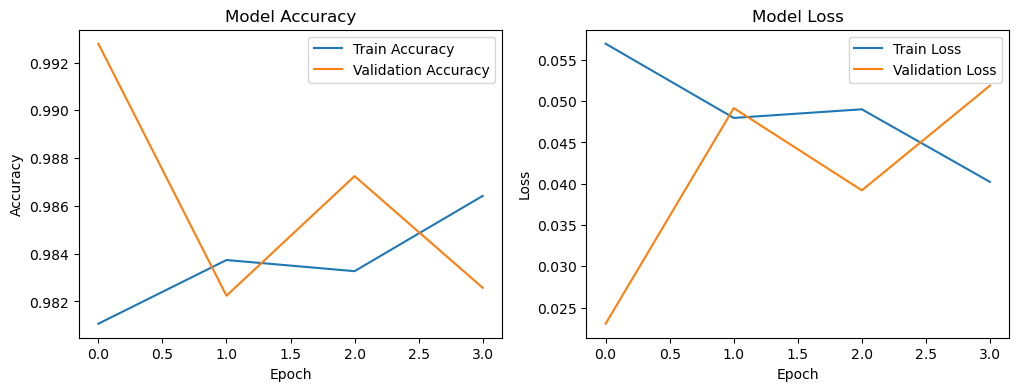

In [151]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_test.history['accuracy'], label='Train Accuracy')
plt.plot(training_test.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_test.history['loss'], label='Train Loss')
plt.plot(training_test.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()